# 1. 프로젝트 실습

### 데이터 불러오기

[데이터타입 통합]
kopo_channel_seasonality_new.csv 파일을 불러온 후
selloutData 변수에 담으세요 이후 
QTY컬럼→실수(float), 이외컬럼→문자(str)로 변경하세요

In [1]:
import pandas as pd

selloutData = \
    pd.read_csv("../dataset/kopo_channel_seasonality_new.csv")

selloutData = selloutData.astype({"REGIONID":str,
                    "PRODUCT":str,
                    "YEARWEEK":str,
                    "QTY":float})

### 1. 데이터 전처리

### A-1. 불량데이터 처리

[불량 데이터 처리]
kopo_channel_seasonality_new.csv 자료를 담은 
selloutData 변수에서
QTY컬럼 음수(반품)인 경우 0, 양수인 경우 기존 QTY 값유지하는 로직을 적용하여 QTY_NEW 컬럼을 추가하세요




In [2]:
### 함수정의: 판매량 데이터를 정제 (-값: 0, 이외 기존값)
### 파라미터 inQty: 실제 판매량
def cleanQty(inQty):

    # 테스트데이터: inQty
    # inQty = 500
    newQty = 0

    if inQty <= 0:
        newQty = 0
    else:
        newQty = inQty

    return newQty

selloutData["NEW_QTY"] = \
    selloutData.QTY.apply(cleanQty)

### A-2. 데이터 통합

[데이터 통합]
selloutData 자료에서 
YEAR, WEEK 컬럼을 생성하고 WEEK 가 52 이하인
데이터만 조회한 후 refinedSelloutData 변수에 담으세요 (YEAR, WEEK는 모두 str)


In [3]:
selloutData["YEAR"] = selloutData.YEARWEEK.str[0:4]
selloutData["WEEK"] = selloutData.YEARWEEK.str[4:6]

refinedSelloutData = selloutData.copy()

In [4]:
refinedSelloutData.shape

(124658, 7)

### B-3. 추세선 도출

0.[데이터 통합]
refinedSelloutData 자료에서 
YEAR, WEEK 컬럼을 생성하고 WEEK 가 52 이하인
데이터만 조회한 후 refinedSelloutData 변수에 담으세요 -> 53주차를 제거한다

In [5]:
refinedSelloutData.shape

(124658, 7)

In [6]:
refinedSelloutData = \
    refinedSelloutData.loc[refinedSelloutData.WEEK != "53"]

1. refinedSelloutData 에서 →
지역, 상품, 연주차 컬럼순으로 오름차순 정렬하여
sortedData 변수에 담으세요

In [7]:
sortKey = ["REGIONID","PRODUCT","YEARWEEK"]

In [8]:
sortedData = refinedSelloutData.sort_values(by=sortKey)

2. [지역, 상품, 연도 별 집계] * 그룹키 = 지역(REGIONID),상품(PRODUCT) 연도(YEAR)
groupKey = ["REGIONID","PRODUCT","YEAR"]
sortedData 에서 지역, 상품, 연도 단위
판매량(QTY_NEW) 의 평균 연산 후
groupData 변수에 담으세요 이후 컬럼명을 QTY_MEAN로 변경하세요


In [9]:
groupKey = ["REGIONID","PRODUCT","YEAR"]

In [10]:
groupData= refinedSelloutData.groupby(by=groupKey)["NEW_QTY"].agg(["mean"]).reset_index()

In [11]:
groupData.rename(columns={"mean":"QTY_MEAN"},inplace=True)

### 1. refinedSelloutData와 groupData를 
### [REGIONID, PRODUCT, YEAR] 키로 조인하여 
### mergedData 변수에 아래와 같이 담으세요


In [12]:
groupKey = ["REGIONID","PRODUCT","YEAR"]

In [13]:
mergedData = \
    pd.merge(left=refinedSelloutData, right=groupData, on= groupKey, how="left")

### 2. 계절성 지수는
### QTY_NEW / QTY_MEAN
### 으로 산출하여 SEASONALITY 컬럼을 생성한다.

In [14]:
mergedData["SEASONALITY"] = mergedData.NEW_QTY / mergedData.QTY_MEAN 

In [15]:
maxLen = mergedData.shape[0]

In [16]:
divPoint = int( maxLen*0.7 )

In [17]:
divPoint

86704

In [18]:
trainingData= mergedData.loc[:divPoint]
testData= mergedData.loc[divPoint:]

### 3. 마지막으로 [지역, 상품, 주차] 별 
### 계절성 지수 평균 값을
### 조별 산출하여 finalResult 변수에 담으세요


In [19]:
groupKeyWeek = ["REGIONID","PRODUCT","WEEK"]

In [20]:
finalResult = \
    mergedData.groupby(by=groupKeyWeek)["SEASONALITY"].agg(["mean"]).reset_index()

In [21]:
finalResult.rename(columns={"mean":"SEASONALITY"},inplace=True)

# 1. 시각화 라인차트

In [22]:
finalResult.loc[finalResult.REGIONID=="A00"].PRODUCT.drop_duplicates()

0      PRODUCT34
52     PRODUCT58
104    PRODUCT59
Name: PRODUCT, dtype: object

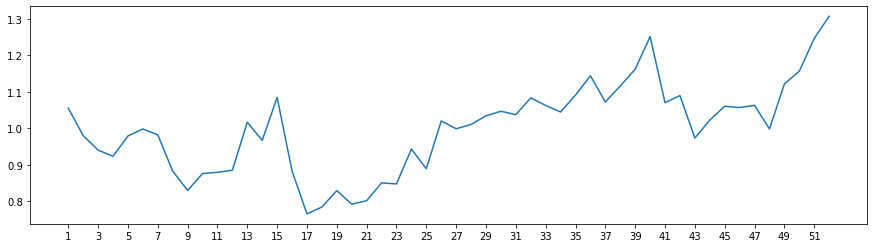

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
regionid = "A00"
product = "PRODUCT59"
target = finalResult.loc[ (finalResult.REGIONID==regionid) & 
                         (finalResult.PRODUCT==product)]

x = target.WEEK.astype(int)
y = target.SEASONALITY
# x = [1,2,3,4,5,6,7]
# y = [1.2,1.3,1.4,1.5,1.6,1.7]

plt.figure(figsize=(15, 4))
plt.xticks( range( min(x), max(x), 2) )
plt.plot(x,y)

In [24]:
# 선택한 조건에 맞는 데이터 추출
targetRegion = "A00"
targetProduct = "PRODUCT34"
targetYear = "2014"

In [25]:
groupData.loc[(groupData.REGIONID==targetRegion) &
              (groupData.PRODUCT==targetProduct) &
              (groupData.YEAR==targetYear)].QTY_MEAN.values[0]

275.96153846153845

### 1. 상관분석

In [26]:
featureData = \
    pd.read_csv("../dataset/feature_regression_example.csv")

# 상관분석은 숫자컬럼에 대해서만 작동한다

In [27]:
import numpy as np

In [28]:
featureData["HOLIDAY_NEW"] = \
    np.where(featureData.HOLIDAY=="Y",1,0)
featureData["PROMOTION_NEW"] = \
    np.where(featureData.PROMOTION=="Y",1,0)

In [29]:
corrDf = featureData.corr()

In [30]:
stdCorr = 0.5

In [31]:
features =  \
    list( corrDf.loc[ (abs(corrDf.QTY) > stdCorr) & (abs(corrDf.QTY) != 1)].index )

In [32]:
# 가격 경쟁력 분석......

In [33]:
features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'PROMOTION_NEW']